In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

In [5]:
def load_single_datacube(file_path):
    """
    Load a single datacube from pickle file
    
    Returns:
    --------
    dict: Datacube data with structure:
        - datacubes: dict of modality arrays (spatial_x, spatial_y, temporal)
        - metadata: dict with event information and parameters
    """
    with open(file_path, 'rb') as f:
        datacube_data = pickle.load(f)
    return datacube_data

def load_all_datacubes(datacube_directory):
    """
    Load all datacubes from directory and create summary
    
    Returns:
    --------
    list: List of datacube dictionaries
    pd.DataFrame: Summary dataframe with key information
    """
    datacube_files = glob.glob(str(Path(datacube_directory) / "habnet_datacube_*.pkl"))
    
    print(f"Found {len(datacube_files)} datacube files")
    
    datacubes = []
    summary_data = []
    
    for file_path in datacube_files:
        try:
            datacube = load_single_datacube(file_path)
            datacubes.append(datacube)
            
            # Extract summary information
            metadata = datacube['metadata']
            summary_data.append({
                'file_path': file_path,
                'stable_event_id': metadata['stable_event_id'],
                'date': metadata['date'],
                'lat': metadata['lat'],
                'lon': metadata['lon'],
                'hab_label': metadata['hab_label'],
                'cell_count': metadata['cell_count'],
                'data_completeness': metadata['data_completeness'],
                'successful_days': metadata['successful_days'],
                'modalities': list(datacube['datacubes'].keys())
            })
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    summary_df = pd.DataFrame(summary_data)
    return datacubes, summary_df

In [6]:
def inspect_datacube_structure(datacube_data):
    """
    Print detailed information about datacube structure
    """
    print("DATACUBE STRUCTURE")
    print("=" * 50)
    
    # Metadata inspection
    metadata = datacube_data['metadata']
    print(f"Event ID: {metadata['stable_event_id']}")
    print(f"Date: {metadata['date']}")
    print(f"Location: ({metadata['lat']:.3f}, {metadata['lon']:.3f})")
    print(f"HAB Label: {metadata['hab_label']} ({'HAB Event' if metadata['hab_label'] == 1 else 'No HAB'})")
    print(f"Cell Count: {metadata['cell_count']:,}")
    print(f"Data Completeness: {metadata['data_completeness']:.1%}")
    print(f"Successful Days: {metadata['successful_days']}/{metadata['config']['temporal_extent_days']}")
    
    # Datacube dimensions
    datacubes = datacube_data['datacubes']
    print(f"\nDATACUBE DIMENSIONS")
    print(f"Available Modalities: {list(datacubes.keys())}")
    
    for modality, data in datacubes.items():
        print(f"\n{modality.upper()}:")
        print(f"  Shape: {data.shape} (spatial_x, spatial_y, temporal)")
        print(f"  Data type: {data.dtype}")
        print(f"  Valid pixels: {np.sum(~np.isnan(data)):,} / {data.size:,} ({np.sum(~np.isnan(data))/data.size:.1%})")
        print(f"  Value range: {np.nanmin(data):.4f} to {np.nanmax(data):.4f}")
    
    # Configuration
    config = metadata['config']
    print(f"\nCONFIGURATION")
    print(f"  Spatial extent: {config['spatial_extent_km']}km x {config['spatial_extent_km']}km")
    print(f"  Spatial resolution: {config['spatial_resolution_km']}km")
    print(f"  Temporal extent: {config['temporal_extent_days']} days")
    print(f"  Grid size: {data.shape[0]} x {data.shape[1]} pixels")


In [7]:
def extract_features_and_labels(datacubes):
    """
    Extract features and labels in format ready for ML
    
    Returns:
    --------
    np.array: Features array (n_samples, n_features)
    np.array: Labels array (n_samples,)
    list: Sample metadata for reference
    """
    features_list = []
    labels_list = []
    metadata_list = []
    
    for datacube in datacubes:
        # Extract label
        label = datacube['metadata']['hab_label']
        
        # Extract features from each modality
        sample_features = []
        
        for modality, data in datacube['datacubes'].items():
            # Flatten spatial-temporal datacube to 1D feature vector
            # flattened = data.flatten()
            flattened = data.copy()
            # print(f'Modality: {modality}')
            # print(f'Data: {data}')
            
            
            # Handle NaN values - replace with 0 or use interpolation
            flattened = np.nan_to_num(flattened, nan=0.0)
            
            sample_features.extend(flattened)
        
        features_list.append(sample_features)
        labels_list.append(label)
        metadata_list.append({
            'event_id': datacube['metadata']['stable_event_id'],
            'date': datacube['metadata']['date'],
            'location': (datacube['metadata']['lat'], datacube['metadata']['lon'])
        })
    
    features = np.array(features_list)
    labels = np.array(labels_list)
    
    print(f"ML DATA READY")
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Class distribution: {np.bincount(labels)} (0=No HAB, 1=HAB)")
    
    return features, labels, metadata_list


In [8]:
def extract_temporal_sequences(datacubes, modality='chlor_a'):
    """
    Extract temporal sequences for LSTM/RNN models
    
    Returns:
    --------
    np.array: Sequences (n_samples, spatial_x, spatial_y, temporal)
    np.array: Labels (n_samples,)
    """
    sequences = []
    labels = []
    
    for datacube in datacubes:
        if modality in datacube['datacubes']:
            # Get the 3D datacube (spatial_x, spatial_y, temporal)
            sequence = datacube['datacubes'][modality]
            
            # Replace NaN with 0
            sequence = np.nan_to_num(sequence, nan=0.0)
            
            sequences.append(sequence)
            labels.append(datacube['metadata']['hab_label'])
    
    sequences = np.array(sequences)
    labels = np.array(labels)
    
    print(f"TEMPORAL SEQUENCES READY")
    print(f"Sequences shape: {sequences.shape} (samples, spatial_x, spatial_y, temporal)")
    print(f"Labels shape: {labels.shape}")
    
    return sequences, labels


In [9]:
def visualize_datacube(datacube_data, modality='chlor_a'):
    """
    Visualize a single datacube across time
    """
    if modality not in datacube_data['datacubes']:
        print(f"Modality '{modality}' not found in datacube")
        return
    
    data = datacube_data['datacubes'][modality]
    metadata = datacube_data['metadata']
    
    # Create subplot for each time step
    n_days = data.shape[2]
    fig, axes = plt.subplots(1, n_days, figsize=(15, 3))
    if n_days == 1:
        axes = [axes]
    
    for day in range(n_days):
        im = axes[day].imshow(data[:, :, day], cmap='viridis', aspect='auto')
        axes[day].set_title(f'Day {day+1}')
        axes[day].set_xlabel('Longitude')
        axes[day].set_ylabel('Latitude')
        plt.colorbar(im, ax=axes[day])
    
    plt.suptitle(f'{modality.upper()} - Event {metadata["stable_event_id"]} (HAB: {metadata["hab_label"]})')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(summary_df):
    """
    Plot distribution of HAB vs No-HAB events
    """
    plt.figure(figsize=(8, 5))
    
    # Class distribution
    plt.subplot(1, 2, 1)
    class_counts = summary_df['hab_label'].value_counts()
    plt.bar(['No HAB', 'HAB'], [class_counts.get(0, 0), class_counts.get(1, 0)])
    plt.title('Class Distribution')
    plt.ylabel('Number of Events')
    
    # Data completeness by class
    plt.subplot(1, 2, 2)
    summary_df.boxplot(column='data_completeness', by='hab_label', ax=plt.gca())
    plt.title('Data Completeness by Class')
    plt.xlabel('HAB Label')
    plt.ylabel('Data Completeness')
    
    plt.tight_layout()
    plt.show()


HABNet Datacube Decoder Example

1. Loading all datacubes...
Found 1368 datacube files

Summary:
                  stable_event_id  hab_label  data_completeness modalities
0     20150118_24.7967_-80.7839_0          0                0.8  [chlor_a]
1     20150119_27.3338_-82.5794_0          0                0.6  [chlor_a]
2      20150120_25.9117_-81.728_0          0                0.6  [chlor_a]
3      20150120_27.057_-82.4436_0          0                0.6  [chlor_a]
4     20150120_29.8694_-81.3077_0          0                0.8  [chlor_a]
...                           ...        ...                ...        ...
1363  20181217_24.9317_-81.4076_0          0                0.8  [chlor_a]
1364    20181218_24.478_-81.717_0          0                0.8  [chlor_a]
1365  20181218_24.5383_-81.4133_0          0                1.0  [chlor_a]
1366  20181219_29.9694_-84.3448_0          0                0.6  [chlor_a]
1367  20181226_27.6093_-82.5646_0          0                1.0  [chlor_a]

[1

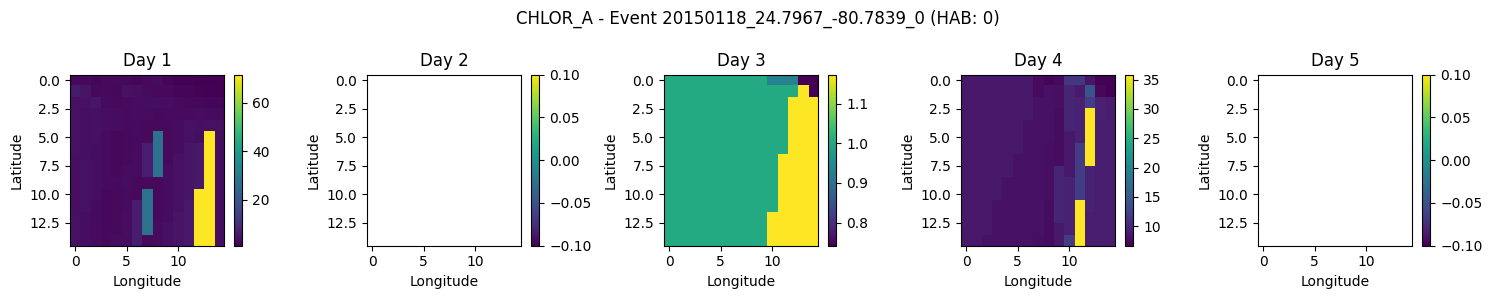


4. Extracting features for traditional ML...
ML DATA READY
Features shape: (1368, 15, 15, 5)
Labels shape: (1368,)
Class distribution: [663 705] (0=No HAB, 1=HAB)

5. Extracting temporal sequences for deep learning...
TEMPORAL SEQUENCES READY
Sequences shape: (1368, 15, 15, 5) (samples, spatial_x, spatial_y, temporal)
Labels shape: (1368,)

6. Plotting data distributions...


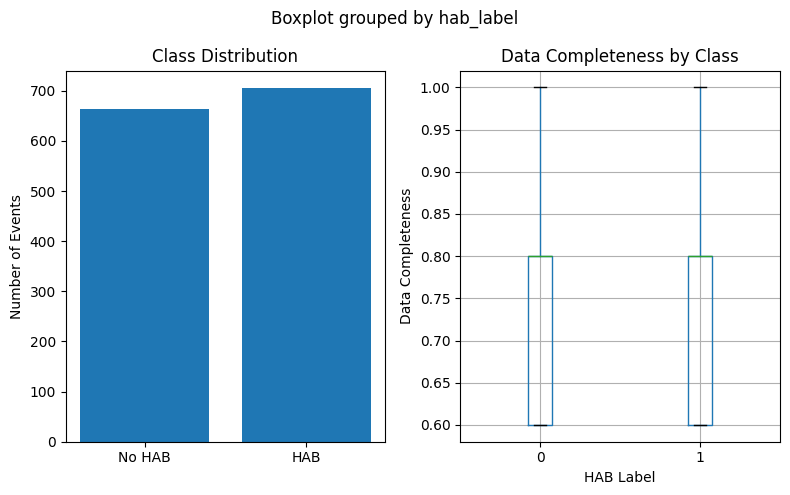


✅ Data is ready for ML! Your friend can now use:
   - features, labels for traditional ML (Random Forest, SVM)
   - sequences, seq_labels for deep learning (CNN+LSTM)


In [10]:
print("HABNet Datacube Decoder Example")
print("=" * 40)

# Set your datacube directory path
datacube_dir = "../Data/processed_datacubes"  # Update this path

# Load all datacubes
print("\n1. Loading all datacubes...")
datacubes, summary_df = load_all_datacubes(datacube_dir)

print(f"\nSummary:")
print(summary_df[['stable_event_id', 'hab_label', 'data_completeness', 'modalities']])

# Inspect first datacube in detail
if len(datacubes) > 0:
    print("\n2. Inspecting first datacube structure...")
    inspect_datacube_structure(datacubes[0])
    
    # Visualize first datacube
    print("\n3. Visualizing first datacube...")
    visualize_datacube(datacubes[0])

# Extract features for traditional ML
print("\n4. Extracting features for traditional ML...")
features, labels, metadata = extract_features_and_labels(datacubes)

# Extract temporal sequences for deep learning
print("\n5. Extracting temporal sequences for deep learning...")
sequences, seq_labels = extract_temporal_sequences(datacubes)

# Plot distributions
print("\n6. Plotting data distributions...")
plot_class_distribution(summary_df)

print("\n✅ Data is ready for ML! Your friend can now use:")
print("   - features, labels for traditional ML (Random Forest, SVM)")
print("   - sequences, seq_labels for deep learning (CNN+LSTM)")


In [8]:
datacube_dir = "../Data/processed_datacubes"  # Update this path

datacubes, summary_df = load_all_datacubes(datacube_dir)

Found 1368 datacube files


In [9]:
features, labels, metadata_list = extract_features_and_labels(datacubes)

ML DATA READY
Features shape: (1368, 15, 15, 5)
Labels shape: (1368,)
Class distribution: [663 705] (0=No HAB, 1=HAB)


In [10]:
def data_augment(X_train, y_train):
    
    augmented_X = []
    augmented_y = []
    
    for x, y in zip(X_train, y_train):
        arr = x.copy()
        Y = y.copy()
        augmented_X.append(x)
        augmented_y.append(y)

        for i in range(4, 0, -1):
            arr[:, :, i:] = 0
            augmented_X.append(arr.copy())
            augmented_y.append(Y)
        
    return np.array(augmented_X), np.array(augmented_y)

In [11]:
X, y = data_augment(features, labels)

In [12]:
X.shape, y.shape

((6840, 15, 15, 5), (6840,))

In [13]:
final_x = []
for x in X:
    final_x.append(x.flatten())

final_x = np.array(final_x)
    

In [14]:
final_x.shape

(6840, 1125)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_x, y, test_size=0.2, random_state=42, shuffle = True)

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)
print(f'Accuracy : {accuracy_score(y_test, pred_1)}')
print(f'Report : {classification_report(y_test, pred_1)}')
print(f'Matrix : {confusion_matrix(y_test, pred_1)}')

Accuracy : 0.7624269005847953
Report :               precision    recall  f1-score   support

           0       0.72      0.85      0.78       688
           1       0.82      0.67      0.74       680

    accuracy                           0.76      1368
   macro avg       0.77      0.76      0.76      1368
weighted avg       0.77      0.76      0.76      1368

Matrix : [[585 103]
 [222 458]]


c:\ProgramData\Anaconda\envs\HAB\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
model_2 = RidgeClassifier()
model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, pred_2)}')
print(f'Report : {classification_report(y_test, pred_2)}')
print(f'Matrix : {confusion_matrix(y_test, pred_2)}')

Accuracy : 0.7485380116959064
Report :               precision    recall  f1-score   support

           0       0.70      0.86      0.77       688
           1       0.82      0.64      0.72       680

    accuracy                           0.75      1368
   macro avg       0.76      0.75      0.75      1368
weighted avg       0.76      0.75      0.75      1368

Matrix : [[592  96]
 [248 432]]


In [19]:
models = {'Model Name': [],
          'Accuracy' : [],
          'Model' : []}

models['Model Name'].append('Logistic Regression')
models['Accuracy'].append(accuracy_score(y_test, pred_1))
models['Model'].append(model_1)

models['Model Name'].append('Ridge Classifier')
models['Accuracy'].append(accuracy_score(y_test, pred_2))
models['Model'].append(model_2)

In [20]:
from sklearn.tree import DecisionTreeClassifier
model_4 = DecisionTreeClassifier()
model_4.fit(X_train, y_train)
pred_4 = model_4.predict(X_test)
print(f'Accuracy : {accuracy_score(y_test, pred_4)}')
print(f'Report : {classification_report(y_test, pred_4)}')
print(f'Matrix : {confusion_matrix(y_test, pred_4)}')

models['Model Name'].append('Decision Tree')
models['Accuracy'].append(accuracy_score(y_test, pred_4))
models['Model'].append(model_4)

Accuracy : 0.9152046783625731
Report :               precision    recall  f1-score   support

           0       0.94      0.88      0.91       688
           1       0.89      0.95      0.92       680

    accuracy                           0.92      1368
   macro avg       0.92      0.92      0.92      1368
weighted avg       0.92      0.92      0.92      1368

Matrix : [[608  80]
 [ 36 644]]


In [21]:
from sklearn.ensemble import RandomForestClassifier
model_5 = RandomForestClassifier()
model_5.fit(X_train, y_train)
pred_5 = model_5.predict(X_test)
print(f'Accuracy : {accuracy_score(y_test, pred_5)}')
print(f'Report : {classification_report(y_test, pred_5)}')
print(f'Matrix : {confusion_matrix(y_test, pred_5)}')

models['Model Name'].append('RAndom Forest')
models['Accuracy'].append(accuracy_score(y_test, pred_5))
models['Model'].append(model_5)

Accuracy : 0.9298245614035088
Report :               precision    recall  f1-score   support

           0       0.97      0.89      0.93       688
           1       0.90      0.97      0.93       680

    accuracy                           0.93      1368
   macro avg       0.93      0.93      0.93      1368
weighted avg       0.93      0.93      0.93      1368

Matrix : [[613  75]
 [ 21 659]]


In [22]:
from xgboost import XGBClassifier

model_6 = XGBClassifier()
model_6.fit(X_train, y_train)
pred_6 = model_6.predict(X_test)
print(f'Accuracy : {accuracy_score(y_test, pred_6)}')
print(f'Report : {classification_report(y_test, pred_6)}')
print(f'Matrix : {confusion_matrix(y_test, pred_6)}')

models['Model Name'].append('XGBoost')
models['Accuracy'].append(accuracy_score(y_test, pred_6))
models['Model'].append(model_6)

Accuracy : 0.9473684210526315
Report :               precision    recall  f1-score   support

           0       0.98      0.91      0.95       688
           1       0.92      0.98      0.95       680

    accuracy                           0.95      1368
   macro avg       0.95      0.95      0.95      1368
weighted avg       0.95      0.95      0.95      1368

Matrix : [[627  61]
 [ 11 669]]


In [23]:
sequences, seq_labels = extract_temporal_sequences(datacubes, 'chlor_a')

TEMPORAL SEQUENCES READY
Sequences shape: (1368, 15, 15, 5) (samples, spatial_x, spatial_y, temporal)
Labels shape: (1368,)


In [24]:
X, y = data_augment(sequences, seq_labels)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle = True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LSTM, Dense, Flatten, TimeDistributed, Dropout
from tensorflow.keras.utils import to_categorical

### Binary Classification

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(150, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

c:\ProgramData\Anaconda\envs\HAB\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - accuracy: 0.5971 - loss: 0.6665 - val_accuracy: 0.7222 - val_loss: 0.5685
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - accuracy: 0.7093 - loss: 0.5553 - val_accuracy: 0.7471 - val_loss: 0.4831
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.7948 - loss: 0.4360 - val_accuracy: 0.8246 - val_loss: 0.3924
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.8650 - loss: 0.2982 - val_accuracy: 0.8684 - val_loss: 0.3242
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.9061 - loss: 0.2023 - val_accuracy: 0.8743 - val_loss: 0.2757
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 33s 97ms/step - accuracy: 0.9321 - loss: 0.1425 - val_accuracy: 0.8787 - val_loss: 0.2464
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.9403 - loss: 0.1224 - val_accuracy: 0.8640 - val_loss: 0.2753
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9401 - loss: 0.1156 - 

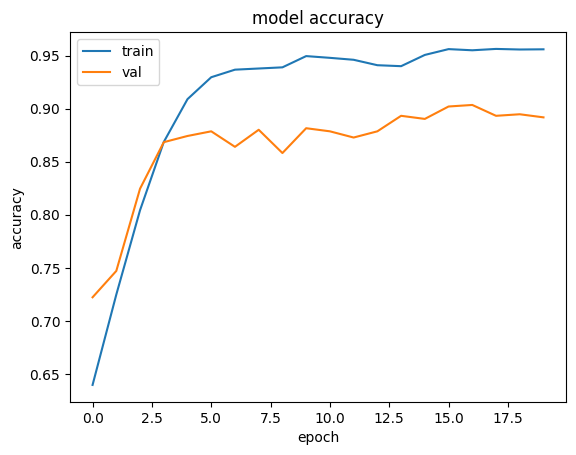

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
scores = model.evaluate(X_test, y_test)

models['Model Name'].append('CNN + LSTM 1')
models['Accuracy'].append(scores[1])
models['Model'].append(model)

print(f'Accuracy : {scores[1]*100}%')

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8748 - loss: 0.6083
Accuracy : 88.45029473304749%


### Multi Class Output

In [30]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [31]:
model_ = Sequential()
model_.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu'), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)))
model_.add(TimeDistributed(Flatten()))
model_.add(LSTM(150, return_sequences=True))
model_.add(Flatten())
model_.add(Dropout(0.2))
model_.add(Dense(20, activation='relu'))
model_.add(Dense(2, activation='softmax'))

model_.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.6043 - loss: 0.6746 - val_accuracy: 0.6754 - val_loss: 0.5890
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7039 - loss: 0.5599 - val_accuracy: 0.7734 - val_loss: 0.5022
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.7989 - loss: 0.4273 - val_accuracy: 0.8333 - val_loss: 0.3958
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.8701 - loss: 0.2952 - val_accuracy: 0.8436 - val_loss: 0.3166
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.9102 - loss: 0.1964 - val_accuracy: 0.8626 - val_loss: 0.2597
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.9149 - loss: 0.1721 - val_accuracy: 0.8904 - val_loss: 0.2599
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.9350 - loss: 0.1271 - val_accuracy: 0.8904 - val_loss: 0.2424
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 33s 96ms/step - accuracy: 0.9418 - loss: 0.1131

In [ ]:
model_.summary()

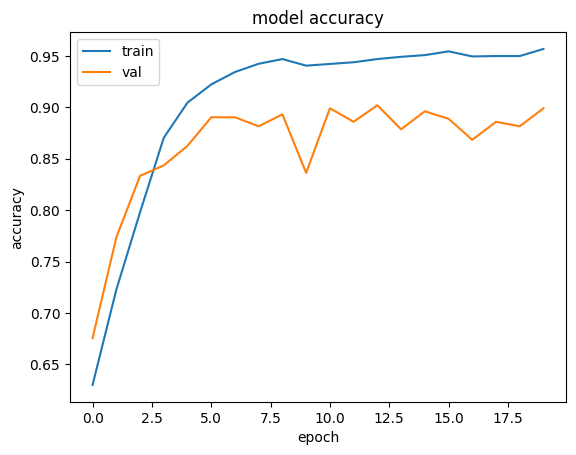

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
models = pd.DataFrame(models)
models

,Model Name,Accuracy,Model
0,Logistic Regression,0.762427,LogisticRegression()
1,Ridge Classifier,0.748538,RidgeClassifier()
2,Decision Tree,0.915205,DecisionTreeClassifier()
3,RAndom Forest,0.929825,"(DecisionTreeClassifier(max_features='sqrt', r..."
4,XGBoost,0.947368,"XGBClassifier(base_score=None, booster=None, c..."
5,CNN + LSTM 1,0.884502,"<Sequential name=sequential, built=True>"
6,CNN + LSTM 2,0.900584,"<Sequential name=sequential_1, built=True>"
